In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
import random
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers, models, regularizers
import keras.callbacks
from keras.layers import Dropout
import tensorflow as tf
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
Path = "C:\\Users\\netan\\Desktop\\ML_Final_Project-master\\ML_Final_Project-master\\Landscape_Classification"

In [3]:
def blurImages(images):
    blurred = np.zeros_like(images)
    for i in range(len(images)):
        B = images[i][:75*75]
        G = images[i][75*75:2*75*75]
        R = images[i][2*(75*75):]
        b = cv2.resize(B,(75,75))
        g = cv2.resize(G,(75,75))
        r = cv2.resize(R,(75,75))
        bgr = np.dstack((b,g,r))
        blur = cv2.GaussianBlur(bgr,(5,5),0)
        blurred[i] = blur.flatten()
        print(i)
    return blurred

In [4]:
def labelToNum(label):
    if label == 'Coast':
        return 1
    if label ==  'Desert':
        return 2
    if label == 'Forest':
        return 3
    if label == 'Glacier':
        return 4
    if label == 'Mountain':
        return 5

In [5]:
def LoadImages(Path):
    Training = False
    if 'Training' in Path:
        data = np.ndarray((2*10000,75*75*3))
        Training = True
    elif 'Validation' in Path:
        data = np.ndarray((1500,75*75*3))
    else:
        data = np.ndarray((500,75*75*3))
    labels = []
    first = True
    paths = os.listdir(Path)
    i = 0
    for Dir in paths:
        dir_time = time.time()
        for file in os.listdir(f"{Path}\\{Dir}"):
            image = cv2.imread(f"{Path}\\{Dir}\\{file}")#RGB
            image = cv2.resize(image,(75,75)) # smaller resolution, don't want too big images
            pixels = image.flatten()
            data[i] = pixels
            i +=1
            labels.append(labelToNum(Dir))
            if Training:
                image = cv2.flip(image,1) # Adding flipped horizontally image to make more training examples
                pixels = image.flatten()
                data[i] = pixels
                i +=1
                labels.append(labelToNum(Dir))

    return data,labels

In [6]:
def LoadData():
    train_data, train_labels = LoadImages(f"{Path}\\Training")
    valid_data, valid_labels = LoadImages(f"{Path}\\Validation")
    test_data, test_labels = LoadImages(f"{Path}\\Testing")
    return train_data,train_labels,valid_data,valid_labels,test_data,test_labels

In [7]:
train_data,train_labels,valid_data,valid_labels,test_data,test_labels = LoadData()

In [8]:
train_data

array([[193., 148.,   3., ..., 130., 122., 108.],
       [233., 219., 207., ..., 192., 197., 206.],
       [229., 215.,  86., ..., 235., 241., 246.],
       ...,
       [174., 190., 206., ...,  64.,  85.,  97.],
       [153., 100.,  20., ...,  13.,  26.,  26.],
       [134.,  81.,   1., ...,  13.,  11.,   8.]])

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [10]:
logic = LogisticRegression(random_state = 5)
scores = cross_val_score(logic, train_data, train_labels, cv=5)

In [11]:
scores

array([0.589 , 0.6255, 0.6185, 0.593 , 0.566 ])

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


In [13]:
base = KNeighborsClassifier(n_neighbors=10)
base.fit(train_data,train_labels)

KNeighborsClassifier(n_neighbors=10)

In [14]:
base.score(train_data,train_labels)

0.63145

In [15]:
n_range = np.arange(1, 30)
valid_scores = []
train_scores = []
for n in n_range:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(train_data,train_labels)
    valid_scores.append(knn.score(valid_data,valid_labels))
    train_scores.append(knn.score(train_data,train_labels))
    print(f'{n} neighbors: train score -> {train_scores[-1]}, valid score -> {valid_scores[-1]}')

1 neighbors: train score -> 0.9989, valid score -> 0.5073333333333333
2 neighbors: train score -> 0.8129, valid score -> 0.47933333333333333
3 neighbors: train score -> 0.75, valid score -> 0.5046666666666667
4 neighbors: train score -> 0.69065, valid score -> 0.5033333333333333
5 neighbors: train score -> 0.6776, valid score -> 0.5006666666666667
6 neighbors: train score -> 0.6628, valid score -> 0.5006666666666667
7 neighbors: train score -> 0.65365, valid score -> 0.504
8 neighbors: train score -> 0.64125, valid score -> 0.504
9 neighbors: train score -> 0.6384, valid score -> 0.5073333333333333
10 neighbors: train score -> 0.63145, valid score -> 0.5026666666666667
11 neighbors: train score -> 0.6303, valid score -> 0.5013333333333333
12 neighbors: train score -> 0.62795, valid score -> 0.5146666666666667
13 neighbors: train score -> 0.62725, valid score -> 0.522
14 neighbors: train score -> 0.62235, valid score -> 0.5186666666666667
15 neighbors: train score -> 0.6212, valid score

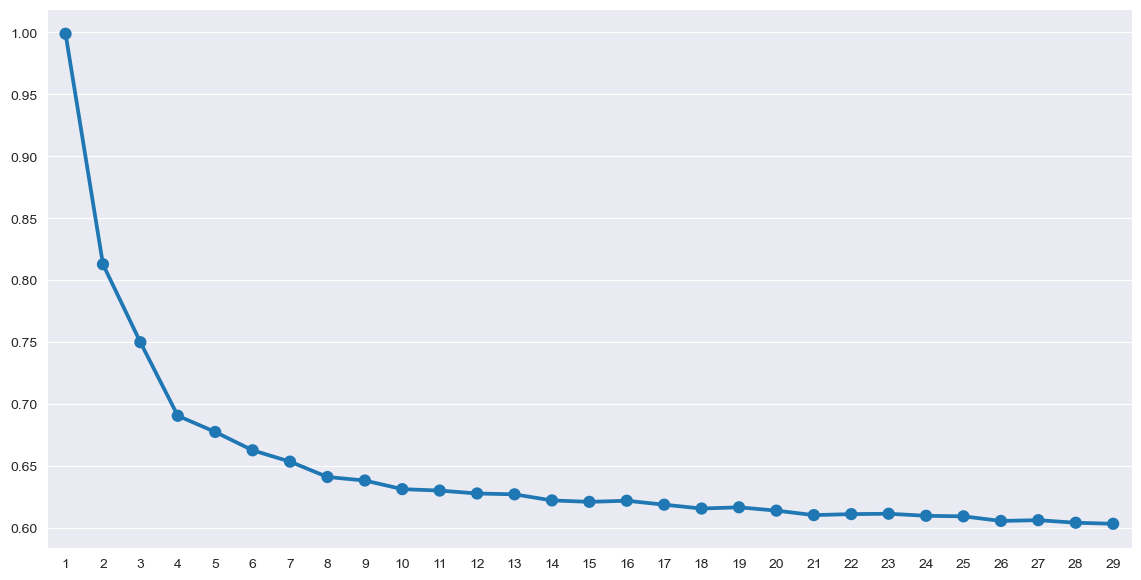

In [16]:
plt.figure(figsize = [14,7])
sns.pointplot(x = n_range, y = train_scores);

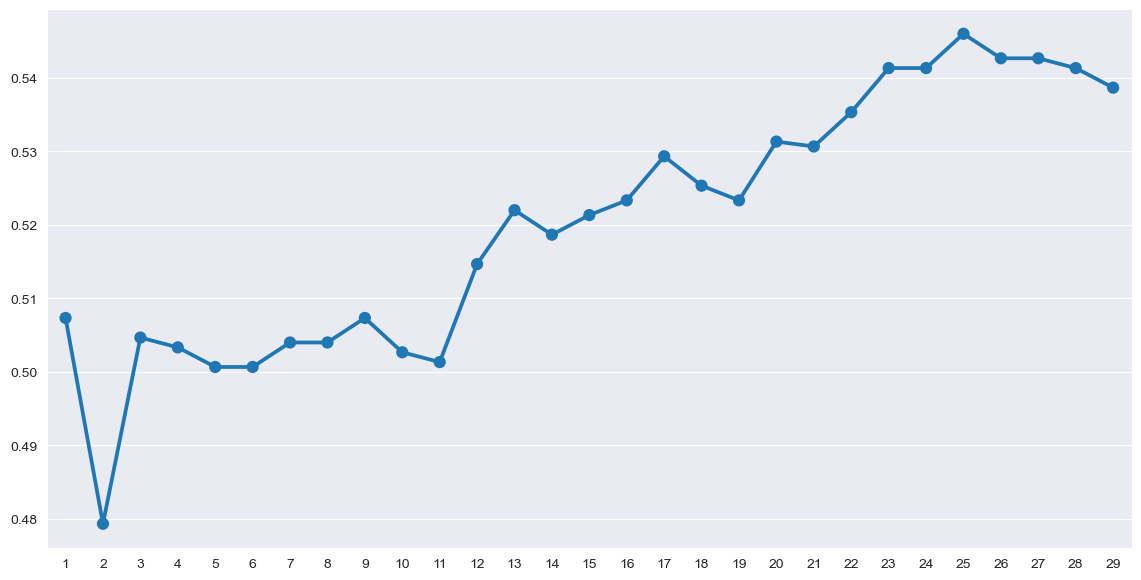

In [17]:
plt.figure(figsize = [14,7])
sns.pointplot(x = n_range, y = valid_scores);

In [18]:
from sklearn.svm import LinearSVC

In [19]:
base_svm = LinearSVC()

In [20]:
base_svm.fit(train_data,train_labels)

LinearSVC()

In [21]:
base_svm.score(train_data,train_labels)

0.95345

In [22]:
base_svm.score(valid_data,valid_labels)

0.456

In [23]:
from sklearn.svm import NuSVC

In [24]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
t_score_svc = []
v_score_svc = []
for kernel in kernels:
    start = time.time()
    clf = NuSVC(kernel=kernel)
    clf.fit(train_data,train_labels)
    v_score_svc.append(clf.score(valid_data,valid_labels))
    t_score_svc.append(clf.score(train_data,train_labels))
    print(f"finished {kernel}, took {time.time() - start} seconds")

finished linear, took 6701.093380451202 seconds
finished poly, took 6469.711397647858 seconds
finished rbf, took 12095.472670078278 seconds
finished sigmoid, took 6241.318146467209 seconds


In [25]:
v_score_svc

[0.572, 0.5966666666666667, 0.622, 0.33866666666666667]

In [26]:
t_score_svc

[0.685, 0.6906, 0.7314, 0.3452]

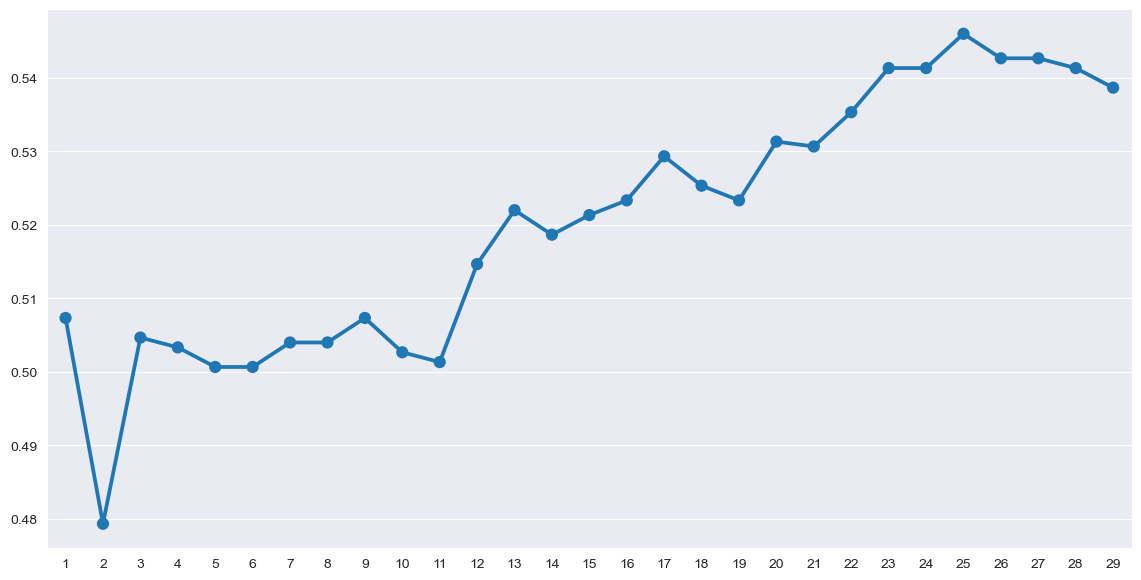

In [27]:
plt.figure(figsize = [14,7])
sns.pointplot(x = n_range, y = valid_scores);

<BarContainer object of 4 artists>

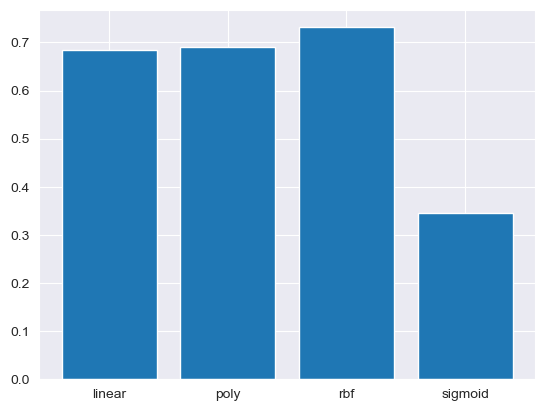

In [28]:
plt.bar(kernels,t_score_svc)

<BarContainer object of 4 artists>

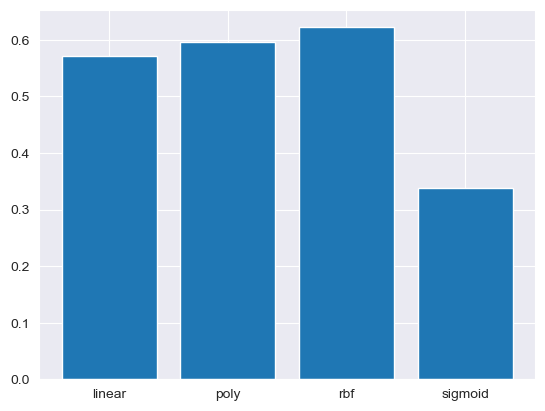

In [29]:
plt.bar(kernels,v_score_svc)

In [66]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers, models, regularizers
import keras.callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dropout
%matplotlib inline
import tensorflow as tf

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [77]:
from keras import layers, models, regularizers
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline
# import tensorflow as tf


TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [9]:
print(train_data.shape)
# print(train_labels.shape)
print(valid_data.shape)
# print(valid_labels.shape)
print(test_data.shape)
# print(test_labels.shape)


(20000, 16875)
(1500, 16875)
(500, 16875)


In [32]:
def normalize(data):
    avg = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    normalized = (data - avg) / sigma
    return normalized
train_data

array([[193., 148.,   3., ..., 130., 122., 108.],
       [233., 219., 207., ..., 192., 197., 206.],
       [229., 215.,  86., ..., 235., 241., 246.],
       ...,
       [174., 190., 206., ...,  64.,  85.,  97.],
       [153., 100.,  20., ...,  13.,  26.,  26.],
       [134.,  81.,   1., ...,  13.,  11.,   8.]])

In [33]:
train_data = normalize(train_data)
valid_data = normalize(valid_data)
test_data = normalize(test_data)
train_data

array([[ 0.58101639,  0.22163241, -1.42463495, ...,  0.63852918,
         0.37801482,  0.13193391],
       [ 1.09917207,  1.27066099,  1.24351835, ...,  1.45625084,
         1.41771291,  1.38742249],
       [ 1.0473565 ,  1.21156078, -0.33906277, ...,  2.02338039,
         2.02766913,  1.89986681],
       ...,
       [ 0.33489244,  0.84218452,  1.23043917, ..., -0.23194873,
        -0.13490291, -0.00898827],
       [ 0.0628607 , -0.48757002, -1.20228884, ..., -0.90459075,
        -0.95279874, -0.91857694],
       [-0.18326325, -0.76829597, -1.45079331, ..., -0.90459075,
        -1.16073836, -1.14917688]])

In [38]:
from sklearn.decomposition import PCA
def doPCA(data):
    pca = PCA().fit(data)

    plt.rcParams["figure.figsize"] = (18,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 16876, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='.', linestyle='--', color='b' ,markersize = 1)

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, 7501, step=600)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.9, color='r', linestyle='-')
    plt.text(0.5, 0.85, '90% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()
    return data

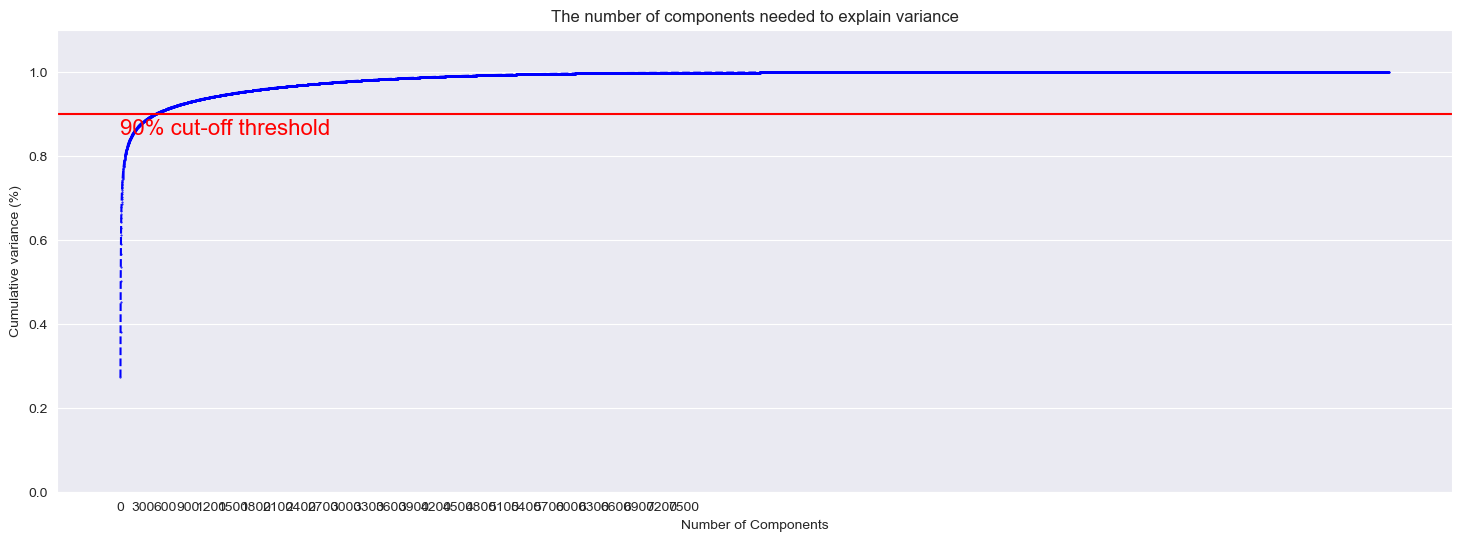

In [39]:
train_data = doPCA(train_data)

In [41]:
train_data.shape

(20000, 16875)

In [59]:
train_data,train_labels,valid_data,valid_labels,test_data,test_labels = LoadData()

In [60]:
print("BEFORE:")
print(train_data.shape)
# print(train_labels.shape)
print(valid_data.shape)
# print(valid_labels.shape)
print(test_data.shape)
# print(test_labels.shape)

BEFORE:
(20000, 16875)
(1500, 16875)
(500, 16875)


In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
scaling_pipeline = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ('pca',PCA(n_components=0.90, random_state=0,svd_solver='auto')),
    ]
)

train_data_scaled = scaling_pipeline.fit_transform(train_data)
valid_data_scaled = scaling_pipeline.transform(valid_data)
test_data_scaled = scaling_pipeline.transform(test_data)

In [45]:
print("AFTER:")
print(train_data_scaled.shape)
# print(train_labels.shape)
print(valid_data_scaled.shape)
# print(valid_labels.shape)
print(test_data_scaled.shape)
# print(test_labels.shape)

AFTER:
(20000, 458)
(1500, 458)
(500, 458)


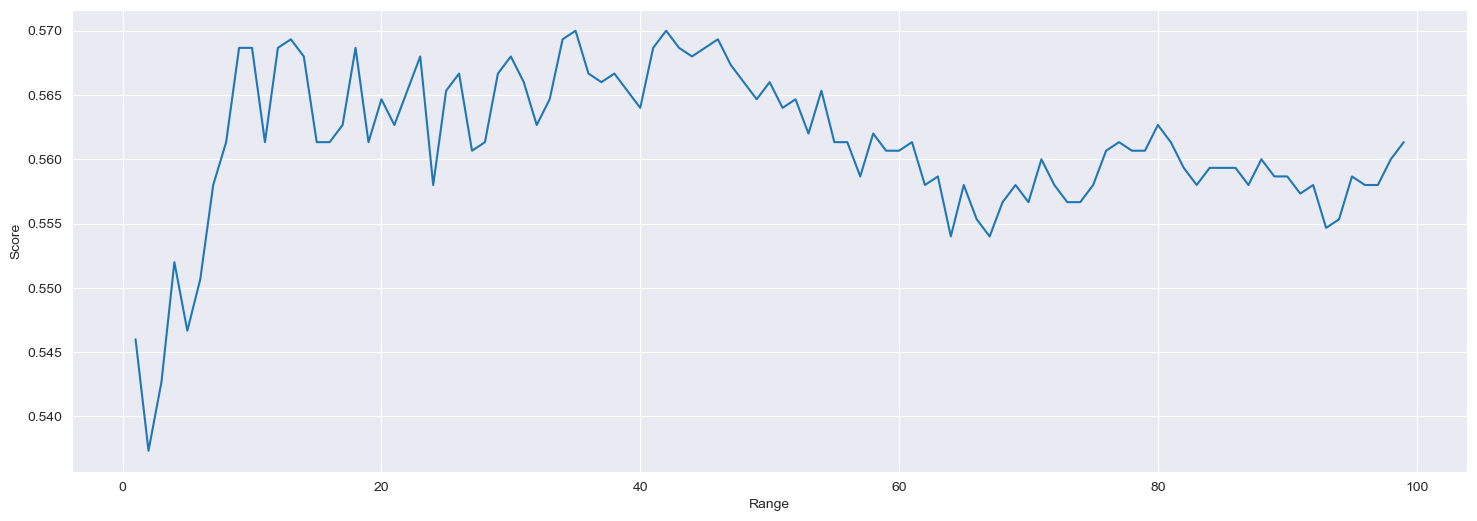

In [49]:
scores = []
for i in range(1, 100):
    knn_i = KNeighborsClassifier(n_neighbors = i)
    knn_i.fit(train_data_scaled,train_labels)
    scores.append(knn_i.score(valid_data_scaled,valid_labels))

plt.plot(range(1, 100),scores)
plt.xlabel("Range")
plt.ylabel("Score")
plt.show()

In [72]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
one_hot_train_labels = encoder.fit_transform([[lab]for lab in train_labels]).toarray()
one_hot_valid_labels = encoder.fit_transform([[lab]for lab in valid_labels]).toarray()
one_hot_test_labels = encoder.fit_transform([[lab]for lab in test_labels]).toarray()
one_hot_train_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [75]:
n_features, n_outputs = train_data.shape[1], 5
CNN = models.Sequential()
CNN.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(n_features, 1), padding='same'))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Dropout(rate=0.35))
CNN.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
CNN.add(layers.MaxPooling1D(pool_size=2))
# CNN.add(layers.Dropout(rate=0.4))
# CNN.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
# CNN.add(layers.Dropout(rate=0.5))
CNN.add(layers.Flatten())
# CNN.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
CNN.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
# CNN.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
CNN.add(layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)))

In [76]:
CNN.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 16875, 32)         192       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 8437, 32)         0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 8437, 32)          0         
                                                                 
 conv1d_23 (Conv1D)          (None, 8433, 64)          10304     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 4216, 64)         0         
 g1D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 269824)          

In [77]:
indices = np.random.permutation(train_data.shape[0])
train_data = train_data[indices]
one_hot_train_labels = one_hot_train_labels[indices]

indices = np.random.permutation(valid_data.shape[0])
valid_data = valid_data[indices]
one_hot_valid_labels = one_hot_valid_labels[indices]

indices = np.random.permutation(test_data.shape[0])
test_data = test_data[indices]
one_hot_test_labels = one_hot_test_labels[indices]

In [78]:
CNN.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
train_labels = np.asarray(train_labels)
valid_labels = np.asarray(valid_labels)
test_labels = np.asarray(test_labels)

In [79]:
callback = [keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=10)]
training = CNN.fit(train_data, one_hot_train_labels, epochs=30, validation_data=(valid_data, one_hot_valid_labels), batch_size=400, callbacks=callback)

Epoch 1/30
50/50 [==============================] - 388s 7s/step - loss: 1215.9363 - accuracy: 0.1981 - val_loss: 9.2588 - val_accuracy: 0.2060
Epoch 2/30
50/50 [==============================] - 347s 7s/step - loss: 9.0658 - accuracy: 0.2009 - val_loss: 8.7596 - val_accuracy: 0.1987
Epoch 3/30
50/50 [==============================] - 302s 6s/step - loss: 8.5604 - accuracy: 0.2022 - val_loss: 8.3633 - val_accuracy: 0.1980
Epoch 4/30
50/50 [==============================] - 302s 6s/step - loss: 8.1850 - accuracy: 0.2075 - val_loss: 8.0199 - val_accuracy: 0.1993
Epoch 5/30
50/50 [==============================] - 321s 6s/step - loss: 7.8730 - accuracy: 0.2133 - val_loss: 7.7415 - val_accuracy: 0.2067
Epoch 6/30
50/50 [==============================] - 301s 6s/step - loss: 7.6180 - accuracy: 0.2132 - val_loss: 7.5155 - val_accuracy: 0.2047
Epoch 7/30
 4/50 [=>............................] - ETA: 4:49 - loss: 7.4939 - accuracy: 0.2319

KeyboardInterrupt: 

In [ ]:
metrics_df = pd.DataFrame(training.history)
metrics_df[["loss","val_loss"]].plot()
metrics_df[["accuracy", "val_accuracy"]].plot()
